In [3]:
import xarray as xr
from ethograph.utils.io import TrialTree
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping, labels_to_rgb
from ethograph.features.changepoints import more_changepoint_features, merge_changepoints
from ethograph.utils.labels import plot_motif_segments_multirow
from matplotlib.patches import Rectangle
from movement.filtering import rolling_filter

# Load data
path = r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\trial_data.nc"
dt = TrialTree.load(path)

ds_kwargs = {
    "individuals": "Freddy",
    "keypoints": "beakTip",
}

motif_mappings = load_motif_mapping(r"C:\Users\Admin\Documents\Akseli\Code\MovFormer\configs_global\mapping.txt")

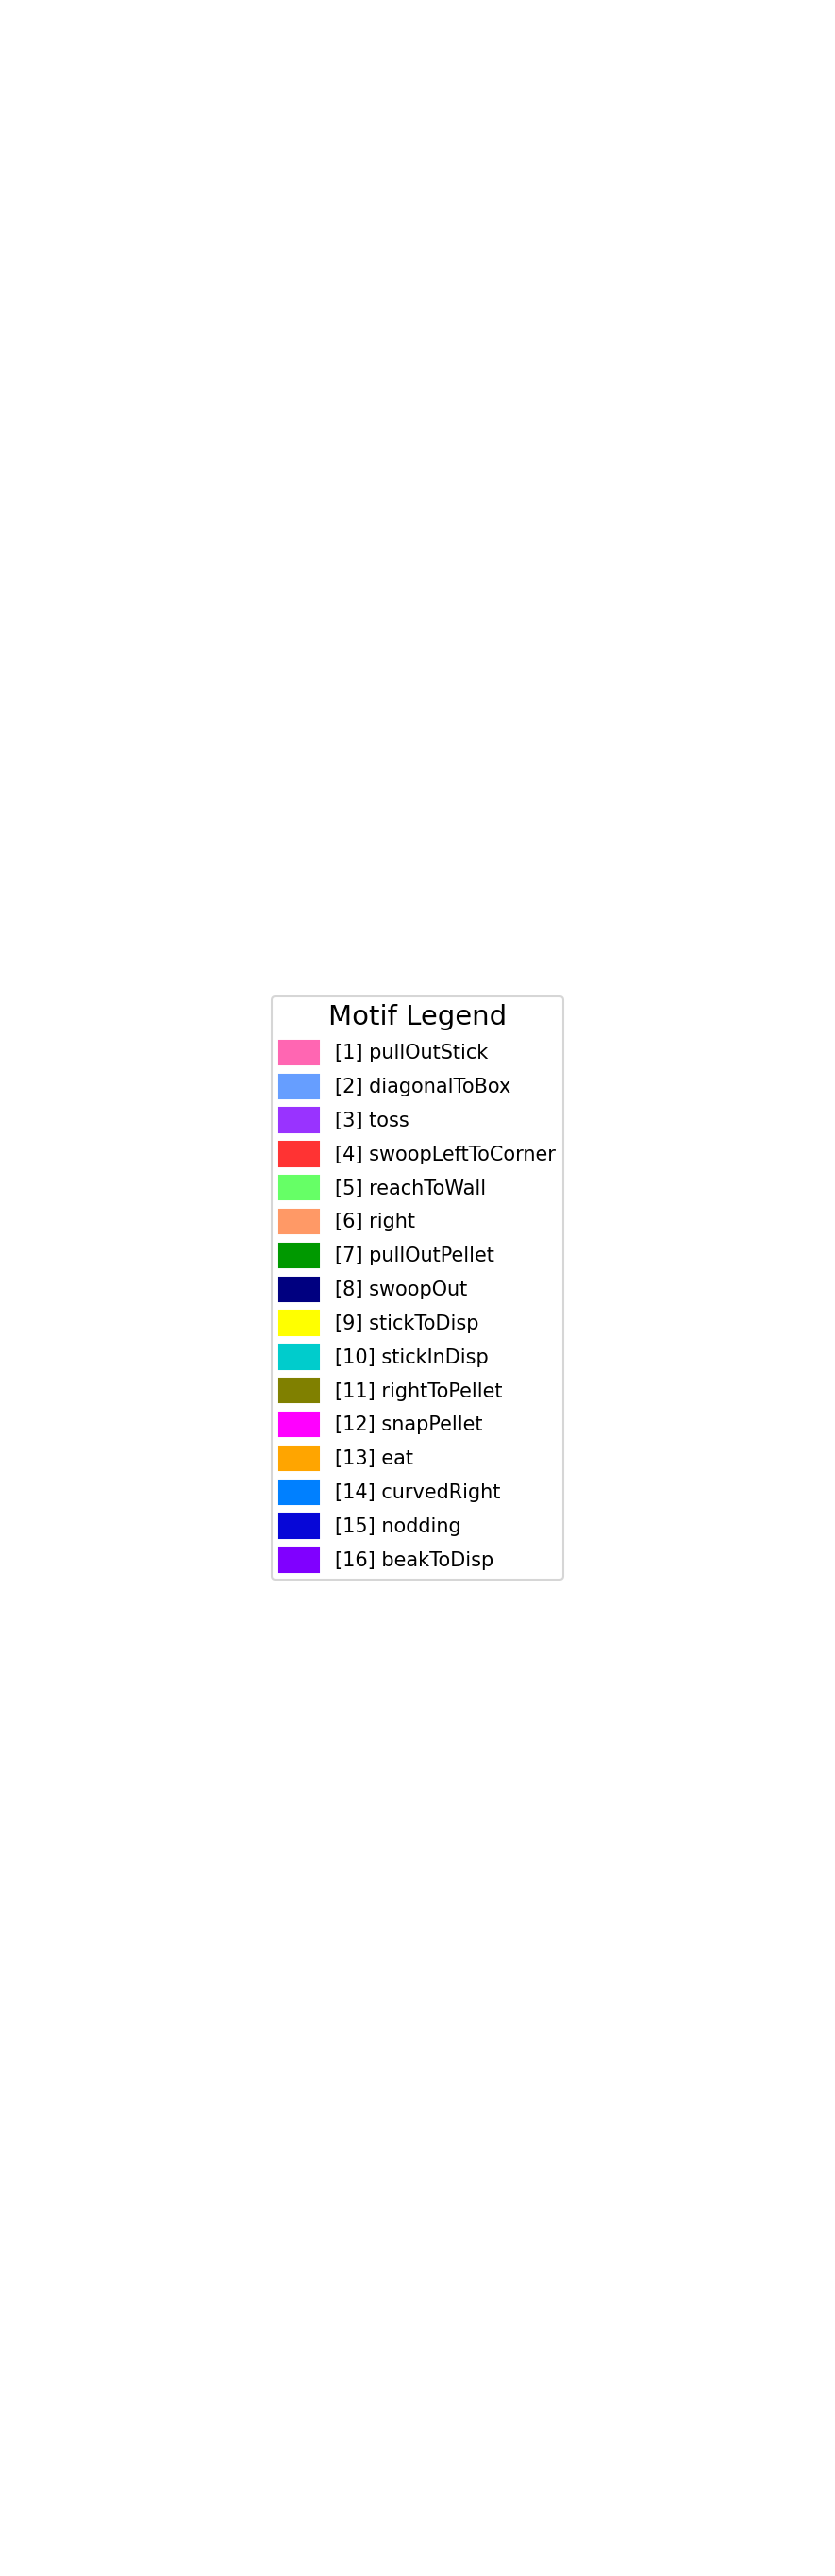

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def add_motif_legend(ax, motif_mappings):
    patches = []
    for motif_id in sorted(motif_mappings.keys()):
        if motif_id == 0:
            continue
        motif = motif_mappings[motif_id]
        patch = mpatches.Patch(color=motif['color'], label=f"[{motif_id}] {motif['name']}")
        patches.append(patch)

    ax.legend(handles=patches, loc='center', fontsize=10, frameon=True, 
              title='Motif Legend', title_fontsize=14, ncol=1,
              columnspacing=1.5, handlelength=2, handleheight=1.5,
              bbox_to_anchor=(0.5, 0.5))
    return ax

fig, ax = plt.subplots(figsize=(, 8))
ax = add_motif_legend(ax, motif_mappings)
ax.set_axis_off()
ax.grid(False)

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05)
fig.savefig("motifnames_1col.eps", bbox_inches='tight')

In [6]:
import xarray as xr
from ethograph.utils.io import TrialTree
import numpy as np
import matplotlib.pyplot as plt
from ethograph.utils.labels import plot_motif_segments, load_motif_mapping, labels_to_rgb
from ethograph.features.changepoints import more_changepoint_features, merge_changepoints
from ethograph.utils.labels import plot_motif_segments_multirow
from matplotlib.patches import Rectangle
from movement.filtering import rolling_filter

style_path = r"C:\Users\Admin\Documents\Akseli\Code\MovFormer\configs_global\style.mplstyle"
plt.style.use(str(style_path))



# Load data
path = r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\trial_data.nc"
dt = TrialTree.load(path)

ds_kwargs = {
    "individuals": "Freddy",
    "keypoints": "beakTip",
}

motif_mappings = load_motif_mapping(r"C:\Users\Admin\Documents\Akseli\Code\MovFormer\configs_global\mapping.txt")

# Define trials
trial_types = ["left pellet", "left pellet", "left pellet", "left pellet", "right pellet", "right pellet", "right pellet", "right pellet", 
               "regrab", "regrab", "regrab", "no pellet", "no pellet"]
trial_nums = [6, 54, 63, 55, 11, 65, 12, 56, 28, 22, 41, 9, 122]


# Trial type groupings (adjusted for reversed order)
trial_type_groups = [
    ("left pellet", 0, 4),      # indices 0-3 (4 left pellet trials)
    ("right pellet", 4, 8),     # indices 4-7 (4 right pellet trials)
    ("regrab", 8, 11),   # indices 8-10 (3 regrab trials)
    ("no pellet", 11, 13) # indices 11-12 (2 no pellet trials)
]

from matplotlib.gridspec import GridSpec

# Create figure with custom GridSpec
fig = plt.figure(figsize=(10, 4))

# Calculate height ratios based on number of trials in each group
height_ratios = [end_idx - start_idx for _, start_idx, end_idx in trial_type_groups]

# Create GridSpec with width ratios: 1/4 for position traces, 3/4 for time series
gs = GridSpec(len(trial_type_groups), 2, figure=fig, 
              height_ratios=height_ratios, width_ratios=[1, 6])

# left pellet column: Position traces (4 subplots with proportional heights)
position_axes = []
for i, (group_name, start_idx, end_idx) in enumerate(trial_type_groups):
    ax = fig.add_subplot(gs[i, 0])
    position_axes.append(ax)
    
    # Plot position traces for this group
    for idx in range(start_idx, end_idx):
        trial_num = trial_nums[idx]
        ds = dt.trial(trial_num)
        
        # Filter position data
        window = int(0.2 * ds.fps)
        ds_copy = ds.copy()
        ds_copy.update({
            "position": rolling_filter(
                ds_copy.position, window, statistic="median"
            )
        })
        
        # Get box boundaries
        box_in = ds.boundary_events.values[2]
        box_out = ds.boundary_events.values[3]
        
        if not (np.isnan(box_in) or np.isnan(box_out)):
            # Convert to integers for indexing
            box_in = int(box_in)
            box_out = int(box_out)
            
            position = ds_copy.position.sel(
                individuals="Freddy", 
                keypoints="stickTip", 
                space=["x", "y"]
            ).values[box_in:box_out, :]


            rgb = labels_to_rgb(ds.labels.isel(time=slice(box_in, box_out)).squeeze().values, motif_mappings)

    
            n_points = len(position[:, 0])

            for i in range(n_points - 1):
                ax.plot(position[i:i+2, 0], position[i:i+2, 1],
                    color=rgb[i], linewidth=2)

    # Remove all axes and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel(group_name.capitalize(), fontsize=9)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

# right pellet column: Time series with motif segments (single plot spanning all rows)
ax_time = fig.add_subplot(gs[:, 1])

row_spacing = 1
max_time = 0

# Reverse the order for time series display
trial_types_reversed = trial_types[::-1]
trial_nums_reversed = trial_nums[::-1]

for idx, (trial_type, trial_num) in enumerate(zip(trial_types_reversed, trial_nums_reversed)):
    ds = dt.trial(trial_num)
    box_in = ds.boundary_events.values[2]
    box_out = ds.boundary_events.values[3]    

    labels = np.array(ds.labels.values)
    
    # Find first non-zero label
    non_zero_indices = np.where(labels != 0)[0]
    if len(non_zero_indices) == 0:
        continue
    start = non_zero_indices[0] - 15
    
    # Prepare time and speed data
    time = ds.time.values[start:] - ds.time.values[start]
    speed = ds.speed.sel(**ds_kwargs).values[start:]
    speed = (speed - np.nanmin(speed)) / (np.nanmax(speed) - np.nanmin(speed))
    speed = np.clip(speed, None, 0.9)
    speed = speed + idx * row_spacing
    
    max_time = max(max_time, time[-1])
    
    # Plot motif segments
    plot_motif_segments_multirow(
        ax_time, time, labels[start:], motif_mappings,
        row_index=idx, row_spacing=row_spacing
    )
    
    # Plot speed trace
    ax_time.plot(time, speed, color='black', linewidth=1, zorder=1)
    
    if not (np.isnan(box_in) or np.isnan(box_out)):
        ax_time.plot(
            [ds.time.values[int(box_in)] - ds.time.values[start]] * 2,
            [idx * row_spacing - 0.1, (idx + 1) * row_spacing - 0.1],
            color='black', linestyle='--', linewidth=1.5
        )
        ax_time.plot(
            [ds.time.values[int(box_out)] - ds.time.values[start]] * 2,
            [idx * row_spacing - 0.1, (idx + 1) * row_spacing - 0.1],
            color='black', linestyle='--', linewidth=1.5
        )

# Adjusted rectangles for reversed order in time series
# Now: no pellet (0-2), regrab (2-5), right pellet (5-9), left pellet (9-13)
trial_type_groups_reversed = [
    ("no pellet", 0, 2),   # First 2 rows (reversed: was last)
    ("regrab", 2, 5),      # Next 3 rows
    ("right pellet", 5, 9),       # Next 4 rows
    ("left pellet", 9, 13)        # Last 4 rows (reversed: was first)
]

# Add rectangles around trial type groups
for trial_type, start_row, end_row in trial_type_groups_reversed:
    rect = Rectangle(
        (0, start_row * row_spacing - 0.1),
        max_time,
        (end_row - start_row) * row_spacing,
        linewidth=2,
        edgecolor='black',
        facecolor='none',
        zorder=-1
    )
    ax_time.add_patch(rect)
    

# Configure time series axis
ax_time.set_ylim(-0.5, len(trial_types) * row_spacing)
ax_time.set_xlim(0, max_time)
ax_time.set_yticks([])
ax_time.set_ylabel('')
ax_time.set_xlabel('Time (s)')

# Remove all spines
for spine in ax_time.spines.values():
    spine.set_visible(False)


plt.savefig("figure1.eps", bbox_inches='tight')

Duplicate key in file 'C:\\Users\\Admin\\Documents\\Akseli\\Code\\MovFormer\\configs_global\\style.mplstyle', line 10 ('font.size: 10')

Bad key text.fontsize in file C:\Users\Admin\Documents\Akseli\Code\MovFormer\configs_global\style.mplstyle, line 16 ('text.fontsize: 10')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


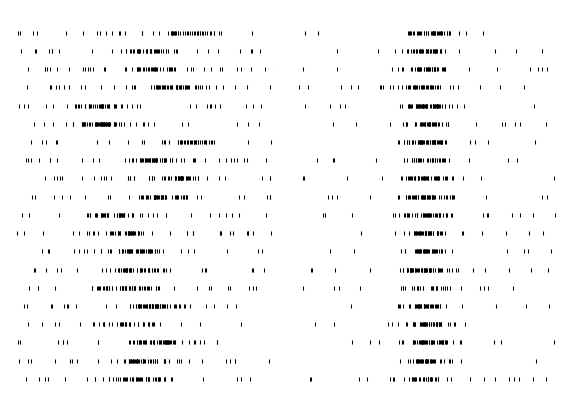

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spike_times(n_neurons: int, time_window: tuple[float, float], 
                        aligned: bool) -> list[np.ndarray]:
    spike_times = []
    alignment_time = 0.5
    
    for neuron in range(n_neurons):
        times = []
        
        if aligned:
            n_background = np.random.poisson(20)
            background_times = np.random.uniform(time_window[0], time_window[1], n_background)
            times.extend(background_times)
            
            n_aligned_spikes = np.random.poisson(40)
            aligned_times = np.random.normal(alignment_time, 0.05, n_aligned_spikes)
            times.extend(aligned_times)
        else:
            n_background = np.random.poisson(40)
            background_times = np.random.uniform(time_window[0], time_window[1], n_background)
            times.extend(background_times)
            
            neuron_shift = np.random.normal(0, 0.1)
            n_weak_aligned = np.random.poisson(40)
            weak_aligned_times = np.random.normal(alignment_time + neuron_shift, 0.06, n_weak_aligned)
            times.extend(weak_aligned_times)
        
        times = [t for t in times if time_window[0] <= t <= time_window[1]]
        spike_times.append(np.array(sorted(times)))
    
    return spike_times

def plot_raster(spike_times: list[np.ndarray], ax: plt.Axes, title: str) -> None:
    for neuron_idx, times in enumerate(spike_times):
        ax.scatter(times, [neuron_idx] * len(times), s=4, c='black', marker='|', linewidths=0.5)
    
    ax.set_ylim(-1, len(spike_times))
    ax.set_xlim(0, 1)

n_neurons = 20
time_window = (0.0, 2.0)

np.random.seed(42)
misaligned_spikes = generate_spike_times(n_neurons, time_window, aligned=False)
aligned_spikes = generate_spike_times(n_neurons, time_window, aligned=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3))

plot_raster(misaligned_spikes, ax1, 'Poor Alignment')
plot_raster(aligned_spikes, ax2, 'Good Alignment')

for ax in [ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)
plt.savefig("raster_example.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


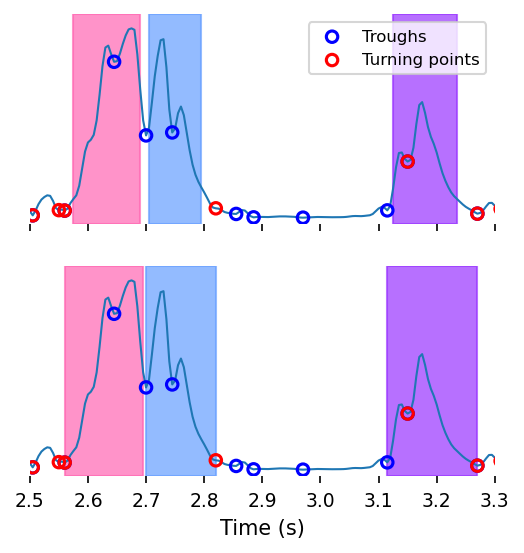

In [ ]:


path = r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\labels\Trial_data_labels_trial122_badly labelled.nc"
dt_bad = TrialTree.load(path)
ds_bad = dt_bad.trial(122)
ds_good = dt.trial(122)

trough_idx = np.where(ds_good.speed_troughs.sel(**ds_kwargs).values)[0]
turning_idx = np.where(ds_good.speed_turning_points.sel(**ds_kwargs).values)[0]
turning_idxs = [turning_idx[i] for i in range(1, len(turning_idx)-1) if turning_idx[i] not in trough_idx]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

# Top subplot - badly labelled
ax1.plot(ds_bad.time, ds_bad.speed.sel(individuals="Freddy", keypoints="beakTip"))
plot_motif_segments(ax1, ds_bad.time, ds_bad.labels.squeeze().values, motif_mappings, is_main=True)


# Bottom subplot - good labels
ax2.plot(ds_good.time, ds_good.speed.sel(individuals="Freddy", keypoints="beakTip"))
plot_motif_segments(ax2, ds_good.time, ds_good.labels.squeeze().values, motif_mappings, is_main=True)


for ax in [ax1, ax2]:
    ax.scatter(ds_bad.time.values[trough_idx], 
                ds_bad.speed.sel(individuals="Freddy", keypoints="beakTip").values[trough_idx], 
                facecolors='none', edgecolors='blue', s=30, linewidths=1.5, 
                zorder=3, label='Troughs')
    ax.scatter(ds_bad.time.values[turning_idx], 
                ds_bad.speed.sel(individuals="Freddy", keypoints="beakTip").values[turning_idx], 
                facecolors='none', edgecolors='red', s=30, linewidths=1.5, 
                zorder=3, label='Turning points')  
    ax.set_xlim(2.5, 3.3)
    ax.set_ylim(-5, 170)
    if ax == ax2:
        ax.set_xlabel('Time (s)')
    ax.set_ylabel('')
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

ax1.legend(loc='upper right', fontsize=8)

plt.savefig("figure2_cp.eps", bbox_inches='tight')

In [25]:
from ethograph.utils.labels import count_continuous_segments


count_continuous_segments(ds.squeeze())


for trial in dt.trials:
    ds = dt.trial(trial)
    counter = count_continuous_segments(ds.squeeze())
    if 6 in ds.labels and 14 in ds.labels:
        print(trial)

132
